<a href="https://colab.research.google.com/github/fornitroll/Object-Detection-with-PyTorch-Kyiv-/blob/master/Lecture1%20PyTorch%20Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome! This is our first lecture in this course and I'm glad to see you here. 

My name is Andrey Nikishaev and I will lead this course where I'll try to teach you as much possible based on my experience in this area.

So the course will go for 3 weeks with 2 lectures in each. 

Questions that may arise during the class you can ask on our Course GitHub page in the Issues: https://github.com/learnml-today/object-detection-with-pytorch


# PyTorch Basics

What we will learn in this lecture:


1.   Static vs Dynamic graphs.
2.   Basics operations, functions, Serialization, etc.
3.   Autograd.
4.   Torch.nn. 
6.   Torchvision. DataLoading, Transformers.
7.   Hub & Ecosystem



In [1]:
# using latest version of PyTorch
!pip install --upgrade torch torchvision

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.3.1)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.4.2)


## Static vs Dynamic Graphs

PyTorch is used Dynamic Graphs, while many other frameworks like Tensorflow(v2 right now use both static and dynamic graphs), MXNet

The difference here is very similar to the difference between dynamic and static programming languages.

#### Static Graph:

Is consists of two steps. First declaring graph by setting input/output shapes of tensors, operations, etc. Second is execution when you push your data through all graph elements to get the result.

That's why for example in TF always exist problems with shapes. Because before running you can get only static shapes, and thus it can make code of the models much harder to read cause you need to use hacks to implement some architectures. In TF2.0(beta) this become even more problematic(and thats, why I moved to PyTorch at that time, because spent time on fight with framework instead of doing work, is not the best plan)

**Pros:**
* Static graph gives more ways to optimize the inference
* Static graph can be implemented in hardware or even [optics](http://www.computationalimaging.org/publications/hybrid-optical-electronic-convolutional-neural-networks/)
* They are faster(but not always)
* It much simpler to distribute graph on many machines (one of the reasons why PyTorch has problems with running on TPU)

**Cons:**
* The main purpose of it is fast and distributed inference, but when it comes to development it becomes much harder to build and debug the code.
* In most cases code is much cleaner
* Some architecture is to complicated when built using a static graph.
* It's impossible to have dynamic size Input/Output in RNNs (Before TF2.0, TF was used [Tensorflow Fold](https://github.com/tensorflow/fold) to handle this)

#### Dynamic Graph:

Do what you want and whenever you want. And this opens very big possibilities in developing bizarre algorithms and architectures.

Pros/Cons - just reverse Pros/Cons of static graph :)


#### Summary

So I would say like this: Static graphs are more for ML Engineers whose main tasks are speed and distribution. And Dynamic graphs are more for ML researches who need simple implementation and debug


## Basics

PyTorch in comparing with TF has a pretty small module's structure. 
In our path we will use: 
* torch - basic ops 
* torch.Tensor - tensor ops
* torch.nn - layers, models, etc
* torch.autograd - automatic differentiation
* torch.optim - Optimizerss like Adam, SGD, etc
* torch.onnx - tools for encode/decode pytorch model to [Onnx format](https://onnx.ai/)
* torch.utils - usefull tools like tensorboard


The first thing you need to know is that PyTorch has many similar functions as Numpy and you can pass Numpy to Tensor and Tensor to Numpy in a very simple way. 

In [2]:
import torch
import numpy

a = numpy.array([1, 2, 3])
t = torch.as_tensor(a)
print(t)
print(type(t.numpy()),t.numpy()) # that's the power of PyTorch. Debug as simple as possible

tensor([1, 2, 3])
<class 'numpy.ndarray'> [1 2 3]


**Device** The second thing is that any Tensor is executing on a device that you set, default is CPU. it may sound not very convenient for the first time, but later you understand that it doesn't take any additional time from you, but on the other way give you awesome flexibility of your computation graph.

In [3]:
t.device

device(type='cpu')

In [4]:
print('GPU exist:', torch.cuda.is_available())
print(t.cuda())
# or 
print(t.to('cuda:0'))
# or 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(t.to(device))

GPU exist: True
tensor([1, 2, 3], device='cuda:0')
tensor([1, 2, 3], device='cuda:0')
tensor([1, 2, 3], device='cuda:0')


**Generators**
To make things interpretable as many other libraries PyTorch uses things called Generators which are used to generate random numbers. By default for all functions created default Generator.

In [5]:
print(torch.normal(mean=torch.arange(1., 11.), std=torch.arange(1, 0, -0.1)))
print(torch.normal(mean=torch.arange(1., 11.), std=torch.arange(1, 0, -0.1)))


g = torch.Generator()
g.manual_seed(41)
print(g.get_state()) # state is a bytes with which we can restore Generator
torch.set_rng_state(g.get_state()) # set our generator as a default by passing it's state
print(torch.normal(mean=torch.arange(1., 11.), std=torch.arange(1, 0, -0.1)))

g = torch.Generator()
g.manual_seed(42)
torch.set_rng_state(g.get_state())
print(torch.normal(mean=torch.arange(1., 11.), std=torch.arange(1, 0, -0.1)))

tensor([-0.2761,  0.7204,  3.3902,  4.7622,  4.1789,  5.9194,  6.9040,  7.9562,
         8.8076,  9.8564])
tensor([0.2663, 1.1778, 3.4568, 4.0629, 3.7537, 6.2979, 7.1356, 8.0108, 9.0327,
        9.9291])
tensor([41,  0,  0,  ...,  0,  0,  0], dtype=torch.uint8)
tensor([1.7906, 1.4231, 3.1328, 4.1087, 4.1234, 6.3121, 7.1997, 8.0247, 9.2689,
        9.9400])
tensor([ 1.3367,  2.1159,  3.1876,  4.1612,  4.3263,  5.9068,  7.8833,  7.8086,
         9.0923, 10.0267])


**Serialization**
For serialization, PyTorch uses the Pickle module from Python. Thus it has all the same problems with saving classes (problem with saving paths). So when saving data, for example from models use only state dict and not model 

In [6]:
x = torch.tensor([0, 1, 2, 3, 4])
torch.save(x, 'tensor.pt')
y = torch.load('tensor.pt')
print(y)

tensor([0, 1, 2, 3, 4])


**Proper way of saving model**

```
the_model = TheModelClass(*args, **kwargs)
...train
torch.save(the_model.state_dict(), PATH)

the_model = TheModelClass(*args, **kwargs)
the_model.load_state_dict(torch.load(PATH))
```


## Autograd - Automatic Differentiation

All tensors in PyTorch has the option that says if there is a need to compute the gradient for it. 

**Why this needed?** 
While working with simple algorithms like linear regression, we can calculate gradients by ourselves. But as the deepness and hardness of our solution grow it becomes hard and not time efficient to calculate these things manually.

Also, the big pain of mathematics functions is that it's very simple to make a typo and very hard to find a mistake. If you will make a mistake in gradient calculation then you can never know what you have but your solution will work worse.

So it's much convenient to control the general logic of solution while leaving gradients for Autograd.

In [7]:
x = torch.autograd.Variable(torch.FloatTensor([1, 2, 3, 4, 5]), requires_grad=True)
# in new version Variable was deprecated and we can use just Tensor
x = torch.tensor([1, 2, 3, 4, 5], dtype=torch.float, requires_grad=True)
def test(x):
    return x * 2
y = test(x)
# calculating gradient on path
# Tensor in the brackets is dummy error response
y.backward(torch.Tensor([2,2,2,2,2])) 
print(x.grad) # getting gradient


tensor([4., 4., 4., 4., 4.])


Analytical check 
```
out = 2
func = x*2
func/dx = 2
grad = func/dx * out = 4
```
If you forget how Backpropagation works you can [read it here](http://cs231n.github.io/optimization-2/) or [watch the lecture of Andrey Karpathy](https://www.youtube.com/watch?v=i94OvYb6noo&list=PLkt2uSq6rBVctENoVBg1TpCC7OQi31AlC&index=4)

Let's do the check with Autograd tool. Just remember that for gradient check you should use Float of double precision in other way error will be too big


In [8]:
x = torch.tensor([1, 2, 3, 4, 5], dtype=torch.double, requires_grad=True)
def test(x):
    return x * 2

torch.autograd.gradcheck(test,x)

True

Another cool thing that you already should notice, is that u can use python operations with Tensors which makes code much readable


In [9]:
x = torch.tensor([1, 2, 3, 4, 5], dtype=torch.float, requires_grad=True)
def test(x):
    return (((x * 2)**1.3) + 2.77) / x
y = test(x)
y.backward(torch.Tensor([2,2,2,2,2])) 
print(x.grad)

tensor([-4.0626, -0.4756,  0.0692,  0.2136,  0.2573])


How to easily block calculation of gradient, useful for inference mode or transfer learning

In [10]:
x = torch.tensor([1, 2, 3, 4, 5], dtype=torch.float, requires_grad=True)
def test(x):
    return (((x * 2)**1.3) + 2.77) / x
with torch.no_grad():
    y = test(x)
print(y.requires_grad)
    

False


**Hooks** Sometimes it's very handy to get the ability to work with gradient and we want to do this in a clear and readable way. That's where PyTorch hooks make a difference


In [11]:
x = torch.tensor([1, 2, 3, 4, 5], dtype=torch.float, requires_grad=True)
def test(x):
    return x * 2
y = test(x)
h = y.register_hook(lambda grad: grad * 2)  # registering backward hook with double the gradient function
y.backward(torch.tensor([2.,2.,2.,2.,2.]))
x.grad

tensor([8., 8., 8., 8., 8.])

**In-place operations**
This type of operation doesn't return new Tensor but changes the data of the current one. In PyTorch, these operations are marked by underscore symbol like torch.add_()

These types of operations used only for one thing - lowering memory consumption, but in real-life projects are used not very often.

In [12]:
x = torch.tensor([1, 2, 3, 4, 5], dtype=torch.float)
x.add_(2)
print(x)
x = torch.tensor([1, 2, 3, 4, 5], dtype=torch.float)
y = x.add(2)
print(x,y)

tensor([3., 4., 5., 6., 7.])
tensor([1., 2., 3., 4., 5.]) tensor([3., 4., 5., 6., 7.])


If you need a custom function you can create it in a very simple way, like this:

In [13]:
class SomeFunction(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        return input * 2

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone() * 2
        return grad_input
    
x = torch.tensor([1, 2, 3, 4, 5], dtype=torch.float, requires_grad=True)
y = SomeFunction.apply(x) # to use our function we need to call `apply`
y.backward(torch.Tensor([2,2,2,2,2]))
print(x.grad)

tensor([4., 4., 4., 4., 4.])


If you have a little bit harder task or need faster execution you can also build C++ or CUDA extensions without big pain in the ass. I will not publish it here cause it out of current context and also [well documented here](https://pytorch.org/tutorials/advanced/cpp_extension.html)

## Torch.NN

Here are you can find all the things that you need to build your Neural Network

So let's try to create our first model. 

**REMEMBER!** PyTorch use format NCHW(Num, Channels, Height, Width) for data and not NHWC as Tensorflow.
This is by default. TF ops can work with this format also see
https://www.tensorflow.org/api_docs/python/tf/nn/conv2d (data_format)


In [14]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        '''
        Here are you implementing all layers that will be used during forward pass
        '''
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5) # input channels, output channels, kernel size
        self.conv2 = nn.Conv2d(20, 20, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        return F.relu(self.conv2(x))
    
# Creating rundom tensor    
x = torch.randn([1,1,10,10], dtype=torch.float, requires_grad=True)
m = Model()
y = m(x)
print(y.shape)

torch.Size([1, 20, 2, 2])


Also, we can implement Model in Sequential way like in Keras

In [15]:
from collections import OrderedDict
# Example of using Sequential
model = nn.Sequential(
          nn.Conv2d(1,20,5),
          nn.ReLU(),
          nn.Conv2d(20,20,5),
          nn.ReLU()
        )

# Example of using Sequential with OrderedDict
model = nn.Sequential(OrderedDict([
          ('conv1', nn.Conv2d(1,20,5)),
          ('relu1', nn.ReLU()),
          ('conv2', nn.Conv2d(20,20,5)),
          ('relu2', nn.ReLU())
        ]))

x = torch.randn([1,1,10,10], dtype=torch.float, requires_grad=True)
y = model(x)
print(y.shape)

torch.Size([1, 20, 2, 2])


Also, we can group Module and Sequential module together

In [16]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.main = nn.Sequential(
          nn.Conv2d(1,20,5),
          nn.ReLU(),
          nn.Conv2d(20,20,5),
        )
        self.cl = nn.ModuleList([nn.Conv2d(20, 20, 1) for i in range(2)])
        self.act = nn.Tanh()

    def forward(self, x):
        x = self.main(x)
        for e in self.cl:
            x = e(x)
        return self.act(x)
    
x = torch.randn([1,1,10,10], dtype=torch.float, requires_grad=True)
m = Model()
y = m(x)
print(y.shape)

torch.Size([1, 20, 2, 2])


In [17]:
# let's look at the state of our model that cary all weights of the model
m.state_dict()

OrderedDict([('main.0.weight',
              tensor([[[[-0.1705, -0.0757,  0.1774,  0.0313,  0.0415],
                        [-0.0012,  0.0399,  0.1680,  0.0962, -0.0726],
                        [ 0.0696, -0.1572, -0.1493,  0.1073, -0.1662],
                        [ 0.1102,  0.1598,  0.0759, -0.0003,  0.1256],
                        [-0.0079,  0.1752,  0.1395,  0.1546, -0.1991]]],
              
              
                      [[[-0.0154, -0.1604, -0.1494, -0.0173, -0.1239],
                        [ 0.0226,  0.1428,  0.0980,  0.0405,  0.1940],
                        [ 0.0608, -0.0307, -0.1497,  0.0321, -0.1481],
                        [-0.0152, -0.1585, -0.0973, -0.0829,  0.0201],
                        [ 0.0369, -0.0138, -0.0992, -0.1874,  0.0616]]],
              
              
                      [[[ 0.1868,  0.1346, -0.1343, -0.1724, -0.1732],
                        [-0.1399, -0.1316,  0.1848, -0.0542,  0.1031],
                        [ 0.0824,  0.0744, -0.1953,  

In [18]:
list(m.children())

[Sequential(
   (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
   (1): ReLU()
   (2): Conv2d(20, 20, kernel_size=(5, 5), stride=(1, 1))
 ), ModuleList(
   (0): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
   (1): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
 ), Tanh()]

There is no difference in PyTorch between Layer and Model both of them are Modules. The only difference is the Function class that we used before, and the difference from Module is that Function doesn't have state and can implement backward pass.

Also as you saw from above, Module includes all weights and params of all it's submodules, the same as if we cast Module to GPU or CPU all submodules also be cast.

Now let's see how we can control training/eval flow in Module (this is used for Dropouts, BatchNorm, etc)

In [19]:
print(m.training)
m.eval()
print(m.training)
m.train()
print(m.training)


True
False
True


**Creating module with custom parameters**
Torch.nn.Parameter wrapper make Tensor to be added as a module parameter automatically and thus can be trained when module params passed to the optimizer

In [0]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1,5) 
        self.alpha = nn.Parameter(torch.ones(1))
    
    def forward(self, x):
        return self.alpha * self.linear(x)

Let's run small training to see how parameters and optimisation process works

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Model(nn.Module):
    def __init__(self, param=True):
        super().__init__()
        self.fc1 = nn.Linear(100,20) # FullyConnected layer
        self.fc2 = nn.Linear(20,1) 

        if param:
            self.alpha = nn.Parameter(torch.ones(1))
        else:
            self.alpha = torch.ones(1)

    def forward(self, x):
        x = self.fc1(x)
        return self.alpha * self.fc2(x)

def test(param=True):

    device = torch.device("cpu")
    model = Model(param).to(device)
    # we optimizing parameters of our model, other parameters will not be optimised if exist
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    x = torch.randn(64, 100, dtype=torch.float)
    y = torch.randn(64, 1, dtype=torch.float)
    # let's see our alpha param
    print('Alpha before',model.alpha)

    model.train()
    for i in range(100):
        # before each iteration we clear all gradients calculated before 
        optimizer.zero_grad()
        output = model(x)
        loss = F.mse_loss(output, y)
        # calculating gradients
        loss.backward()
        # optimizing
        optimizer.step()
        # .item() is simple way to get value from scalar
        if i % 25 == 0:
            print(i, loss.item())

    # saving state of the model
    torch.save(model.state_dict(), 'test.pth')

    # let's see our alpha param
    print('Alpha after',model.alpha)
    
    
print('WITHOUT PARAM')
test(False)
print()
print('WITH PARAM')
test(True)

WITHOUT PARAM
Alpha before tensor([1.])
0 1.4165371656417847
25 0.5825823545455933
50 0.21680879592895508
75 0.06441058963537216
Alpha after tensor([1.])

WITH PARAM
Alpha before Parameter containing:
tensor([1.], requires_grad=True)
0 0.9010047316551208
25 0.28142839670181274
50 0.04832739010453224
75 0.00800687912851572
Alpha after Parameter containing:
tensor([1.0515], requires_grad=True)


Now let's load our saved model

In [22]:
m = Model()
m.load_state_dict(torch.load('test.pth'))
m.alpha

Parameter containing:
tensor([1.0515], requires_grad=True)

There is a small hack that helps during the distribution of models or just saving training arguments.

Because the state of the model is a direct you can add any data to it before saving. In such way, you can save training and model arguments. The only thing, you need to remove them from dict before passing to load_state_dict() function.

**Setting the layer weights** In PyTorch there is no such thing as in TF/Keras when you set weight initializer in a layer class init call. In PyTorch, you need explicitly set them (of course there is initialization in all standard layers)

In [23]:
x = nn.Linear(1,3)
print(x.state_dict())
print(x.weight)
print(x.bias)
x.bias.data = torch.tensor([1.13,1.14,1.15])
print('-----------')
print(x.state_dict())

OrderedDict([('weight', tensor([[-0.5073],
        [ 0.9527],
        [-0.1675]])), ('bias', tensor([-0.0396, -0.4210, -0.5255]))])
Parameter containing:
tensor([[-0.5073],
        [ 0.9527],
        [-0.1675]], requires_grad=True)
Parameter containing:
tensor([-0.0396, -0.4210, -0.5255], requires_grad=True)
-----------
OrderedDict([('weight', tensor([[-0.5073],
        [ 0.9527],
        [-0.1675]])), ('bias', tensor([1.1300, 1.1400, 1.1500]))])


Besides adding this by hand, we can use module **torch.nn.init** that have many init functions already defined

In [24]:
x = nn.Linear(1,3)
print(x.state_dict())
print('-----------')
torch.nn.init.xavier_normal_(x.weight)
torch.nn.init.ones_(x.bias)
print(x.state_dict())

OrderedDict([('weight', tensor([[ 0.2648],
        [-0.6914],
        [ 0.0852]])), ('bias', tensor([ 0.5860, -0.4049,  0.0713]))])
-----------
OrderedDict([('weight', tensor([[-0.0424],
        [ 0.5342],
        [ 1.1801]])), ('bias', tensor([1., 1., 1.]))])


## Useful libs. Torchvision

PyTorch comes up with 3 cool extending libraries: [vision](https://github.com/pytorch/vision), [audio](https://github.com/pytorch/audio), [text](https://github.com/pytorch/text)

But as our area is object detection so we will focus on **Torchvision** and also we will use **torch.utils.data** for DataLoader

In [25]:
import torchvision
from torchvision import transforms
simple = transforms.Compose([
    transforms.ToTensor(), # converts to [0,1] interval
])
#let's download MNIST dataset
mnist_trainset = torchvision.datasets.MNIST('./mnist', download=True,  transform=simple) 

0it [00:00, ?it/s]

9920512it [00:01, 9745681.02it/s]                            


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 141536.29it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


1654784it [00:00, 2288659.68it/s]                            
0it [00:00, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


8192it [00:00, 53630.53it/s]            


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!


Now lets load data and look what we get

is pinned True
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]]) tensor([5, 0])


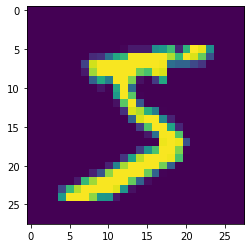

In [26]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
# now get data loader
mnist_loader = DataLoader(mnist_trainset, batch_size=2, pin_memory=True, drop_last=True) 
for img, label in mnist_loader:
    print('is pinned', img.is_pinned())
    print(img, label)
    plt.imshow(img[0][0])
    plt.show()
    break

**pin_memory=True** passed to DataLoader make it put Tesnors to pinned memory which increases the speed of transferring it to CUDA-devices

**drop_last=True** make all batches be the same size, in other cases, the last batch can be smaller

List of all available datasets you can [find here](https://pytorch.org/docs/stable/torchvision/datasets.html)

**Transforms** are used to augment, normalize, convert data. Torchvision transforms using the PIL library.
**WARNING!** PIL library has a bad habit to use image color profiles silently, and this leads to many problems in training. So before running any training remove color profiles from images (this can be done with ImageMagick tool: mogrify -strip *.jpg)

is pinned True
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]]) tensor([5])


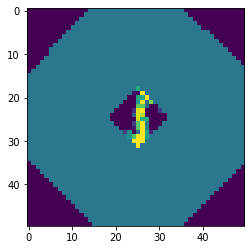

In [27]:
trans = transforms.Compose([
    transforms.CenterCrop(10),
    transforms.Pad(20, fill=100),
    transforms.RandomAffine((-45,45)),
    transforms.ToTensor(), # converts to [0,1] interval
])
#let's download MNIST dataset
mnist_trainset = torchvision.datasets.MNIST('./mnist', download=True,  transform=trans) 
mnist_loader = DataLoader(mnist_trainset, batch_size=1, pin_memory=True, drop_last=True) 
for img, label in mnist_loader:
    print('is pinned', img.is_pinned())
    print(img, label)
    plt.imshow(img[0][0])
    plt.show()
    break

Of course, you can use other augmentation and transformation libraries. PyTorch doesn't force you to use some internal pipeline or something, its just set of tools and Autograd

Another cool thing in that library that it comes up with many state-of-the-art models on classification, object detection, segmentation, face keypoint detection, vide classification.

In [28]:
model = torchvision.models.vgg16(pretrained=True, progress=True)
print(list(model.children()))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:13<00:00, 42.4MB/s]


[Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_s

As you see model consist of two blocks features and classifier which makes much simpler to make feature extractor from the model

In [29]:
model = torchvision.models.vgg16(pretrained=True, progress=True)
x = torch.randn((1,3,256,256))
y = model(x)
print(y.shape)

y = model.features(x)
print(y.shape)

# using forward hook
outputs = []
def hook(module, input, output):
    outputs.append(output)

model.features[3].register_forward_hook(hook)
model(x)
print(outputs[0].shape)

torch.Size([1, 1000])
torch.Size([1, 512, 8, 8])
torch.Size([1, 64, 256, 256])


In some situation, there is a need to cut a network (if you need output from some exact layer)

In [30]:
model = torchvision.models.vgg16(pretrained=True, progress=True)
new_model = torch.nn.Sequential(*(list(model.features.modules())[0][:10]))
print(list(model.features.modules())[0][:10])
x = torch.randn((1,3,256,256))
y = new_model(x)
print(y.shape)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
torch.Size([1, 128, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


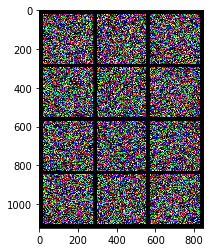

In [31]:
# fast way to plot images in a grid
import matplotlib.pyplot as plt
import numpy as np
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

x = torch.randn((12,3,256,256))
show(torchvision.utils.make_grid(x, nrow=3, padding=20))

Also Torchvision implements few operations that useful during object detection. Like [Non-Maxima Supression(NMS), ROI Align, ROI Pool](https://pytorch.org/docs/stable/torchvision/ops.html)


## PyTorch.HUB

Another cool thing that copying the idea of TF.Hub. It's a place where you can publish and use pretrained models

https://pytorch.org/hub

In [32]:
model = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)
print(list(model.children()))

Downloading: "https://github.com/pytorch/vision/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 45.6MB/s]


[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

## Ecosystem

PyTorch is growing fast and with each day something new and interesting coming out.

You can check it here:
https://pytorch.org/ecosystem

# Summary and small homework

Today we made a small step in the way of simple development of ML solutions, we learned basic blocks of PyTorch, and i hope to understand the power behind its simplicity.

To get some practical fixation I propose you to write some simple AutoEncoder that will use the MNIST dataset and which should remove Gaussian noise from input images(don't forget to add it :) ). 
If you don't know what is AutoEncoder you can check this tutorial for Keras 
https://blog.keras.io/building-autoencoders-in-keras.html

For those who want something bigger, you can try to write a Style Transfer Model.
Here is an example in TensorFlow: https://www.tensorflow.org/tutorials/generative/style_transfer

The main target of this homework is so you understand how to use different parts of PyTorch to build a network. The quality of the results of networks is not needed.

Questions can be asked here: https://github.com/learnml-today/object-detection-with-pytorch